In [ ]:
import numpy as np
import pickle
import cv2
import os
import matplotlib.pyplot as plt
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from keras.utils.data_utils import get_file
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dimension of resized image
DEFAULT_IMAGE_SIZE = tuple((256, 256))

# Path to the dataset folder
root_dir = './drive/MyDrive'

train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'valid')

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, DEFAULT_IMAGE_SIZE)  
            image = cv2.bilateralFilter(src=image, d=9, sigmaColor=75, sigmaSpace=75)   
            resultimage = np.zeros((800, 800))
            image = cv2.normalize(image, resultimage, 0,250, cv2.NORM_MINMAX) 
            b,g,r = cv2.split(image)
            rgb_img = cv2.merge([r,g,b])
            gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
            ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
            # noise removal
            kernel = np.ones((2,2),np.uint8)
            #opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
            closing = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel, iterations = 2)
            # sure background area
            sure_bg = cv2.dilate(closing,kernel,iterations=3)
            # Finding sure foreground area
            dist_transform = cv2.distanceTransform(sure_bg,cv2.DIST_L2,3)
            # Threshold
            ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)
            # Finding unknown region
            sure_fg = np.uint8(sure_fg)
            unknown = cv2.subtract(sure_bg,sure_fg)
            # Marker labelling
            ret, markers = cv2.connectedComponents(sure_fg)
            # Add one to all labels so that sure background is not 0, but 1
            markers = markers+1
            # Now, mark the region of unknown with zero
            markers[unknown==255] = 0
            markers = cv2.watershed(image,markers)
            image[markers == -1] = [255,0,0]
            return (image)
            
        else:
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    plant_disease_folder_list = listdir(train_dir)

    for plant_disease_folder in plant_disease_folder_list:
        print(f"[INFO] Processing {plant_disease_folder} ...")
        plant_disease_image_list = listdir(f"{train_dir}/{plant_disease_folder}/")

        for image in plant_disease_image_list[:1990]:
            image_directory = f"{train_dir}/{plant_disease_folder}/{image}"
            if image_directory.endswith(".jpg")==True or image_directory.endswith(".JPG")==True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_disease_folder)

    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

# Transform the loaded training image data into numpy array
np_image_list = np.array(image_list, dtype=np.float16) / 225.0


# Check the number of images loaded for training
image_len = len(image_list)
print(f"Total number of images: {image_len}")

[INFO] Loading images ...
[INFO] Processing Apple scab ...
[INFO] Processing Apple black rot ...
[INFO] Processing Apple cedar_apple_rust ...
[INFO] Processing Apple healthy ...
[INFO] Processing Cherry_(sour)_healthy ...
[INFO] Processing Cherry_(sour)_powdery mildew ...
[INFO] Processing Corn_Cercospora leaf spot ...
[INFO] Processing Corn_Common rust ...
[INFO] Processing Corn healthy ...
[INFO] Processing Corn_northern leaf blight ...
[INFO] Processing Grape black rot ...
[INFO] Processing Grape_esca(black measles) ...
[INFO] Processing Grape healthy ...
[INFO] Processing Grape leaf blight ...
[INFO] Processing Peach bacterial spot ...
[INFO] Processing Peach healthy ...
[INFO] Processing Pepper bell bacterial spot ...
[INFO] Processing Pepper bell healthy ...
[INFO] Processing Potato Early blight ...
[INFO] Processing Potato late blight ...
[INFO] Processing Potato healthy ...
[INFO] Processing Strawberry healthy ...
[INFO] Processing Strawberry leaf scorch ...
[INFO] Processing T

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)

pickle.dump(label_binarizer,open('plant_disease_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print("Total number of classes: ", n_classes)

Total number of classes:  33


In [ ]:
print("[INFO] Splitting data to train and test...")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Splitting data to train and test...


In [ ]:
EPOCHS = 10
STEPS = 100
LR = 1e-3
BATCH_SIZE = 32
WIDTH = 256
HEIGHT = 256
DEPTH = 3

In [ ]:
model = Sequential()
inputShape = (HEIGHT, WIDTH, DEPTH)
chanDim = -1

if K.image_data_format() == "channels_first":
    inputShape = (DEPTH, HEIGHT, WIDTH)
    chanDim = 1

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [ ]:
from tensorflow.keras.optimizers import Adam
LR = 1e-3
EPOCHS=25
# Initialize optimizer
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)

# Compile model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train model
print("[INFO] Training network...")
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // BATCH_SIZE,
                     epochs=EPOCHS, 
                    verbose=1)

[INFO] Training network...
Epoch 1/25
41/41 [==============================] - 297s 7s/step - loss: 2.8471 - accuracy: 0.3012 - val_loss: 5.1611 - val_accuracy: 0.0360
Epoch 2/25
41/41 [==============================] - 295s 7s/step - loss: 1.1916 - accuracy: 0.6483 - val_loss: 6.2734 - val_accuracy: 0.0330
Epoch 3/25
41/41 [==============================] - 298s 7s/step - loss: 0.6397 - accuracy: 0.8102 - val_loss: 10.4764 - val_accuracy: 0.0330
Epoch 4/25
41/41 [==============================] - 295s 7s/step - loss: 0.3020 - accuracy: 0.9142 - val_loss: 9.8705 - val_accuracy: 0.0330
Epoch 5/25
41/41 [==============================] - 302s 7s/step - loss: 0.1581 - accuracy: 0.9654 - val_loss: 7.5371 - val_accuracy: 0.0420
Epoch 6/25
41/41 [==============================] - 292s 7s/step - loss: 0.1077 - accuracy: 0.9767 - val_loss: 9.0055 - val_accuracy: 0.0721
Epoch 7/25
41/41 [==============================] - 295s 7s/step - loss: 0.0789 - accuracy: 0.9842 - val_loss: 6.2890 - val_ac

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")


[INFO] Calculating model accuracy
11/11 [==============================] - 17s 2s/step - loss: 1.6146 - accuracy: 0.6246
Test Accuracy: 62.46246099472046


In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_train, y_train)
print(f"Train Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
42/42 [==============================] - 72s 2s/step - loss: 7.2708e-04 - accuracy: 1.0000
Train Accuracy: 100.0


In [ ]:
print("[INFO] Saving model...")
KERAS_MODEL_NAME = 'model_plant.h5'
model.save(KERAS_MODEL_NAME)
pickle.dump(model,open('plant_disease_classification_model.pkl', 'wb'))

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://f292ad07-1560-4ac4-9a3f-7c7b4ff4b1a2/assets


In [ ]:
print("[INFO] Saving label transform...")
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

[INFO] Saving label transform...


In [ ]:
filename = 'plant_disease_classification_model.pkl'
model = pickle.load(open(filename, 'rb'))

# Load labels
filename = 'plant_disease_label_transform.pkl'
image_labels = pickle.load(open(filename, 'rb'))

In [ ]:
def predict_disease(image_path):
    image_array = convert_image_to_array(image_path)
    np_image = np.array(image_array, dtype=np.float16) / 225.0
    np_image = np.expand_dims(np_image,0)
    plt.imshow(plt.imread(image_path))
    result = model.predict(np_image)
    classes_x=np.argmax(result,axis=1)
    print((image_labels.classes_[classes_x][0]))

Potato Early blight


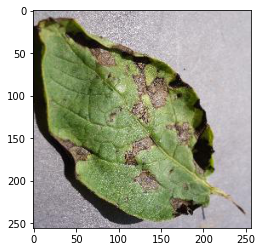

In [ ]:
predict_disease('/content/drive/MyDrive/valid/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170 (1).JPG')

Apple cedar_apple_rust


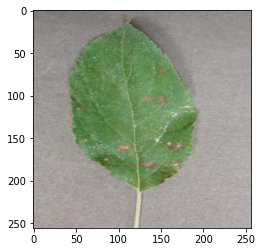

In [ ]:
predict_disease('/content/drive/MyDrive/train/Apple cedar_apple_rust/0a41c25a-f9a6-4c34-8e5c-7f89a6ac4c40___FREC_C.Rust 9807 - Copy.JPG')

Strawberry healthy


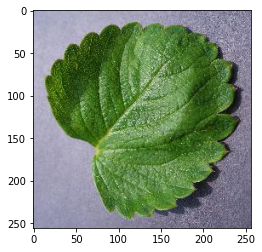

In [ ]:
predict_disease('/content/drive/MyDrive/train/Strawberry healthy/00e9a277-ca5e-4350-95ce-8b2918b69fb9___RS_HL 4667.JPG')

Grape black rot


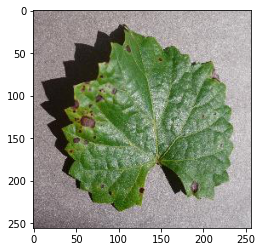

In [ ]:
predict_disease('/content/drive/MyDrive/train/Grape black rot/00cff577-afd4-4e36-ac9c-a52aa6ae5949___FAM_B.Rot 0508.JPG')

Potato late blight


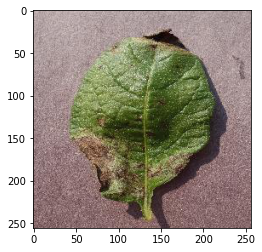

In [ ]:
predict_disease('/content/drive/MyDrive/test/Potato Late blight/00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG')

In [ ]:
TF_LITE_MODEL_FILE_NAME = "model_plant.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert() 

INFO:tensorflow:Assets written to: /tmp/tmp2l2ad9ja/assets


INFO:tensorflow:Assets written to: /tmp/tmp2l2ad9ja/assets


In [ ]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

232472504

In [ ]:
with open('labels.txt', 'w') as f:
  f.write('\n'.join(label_binarizer.classes_))